# Hardware challenge 

## Introduction 
Welcome to the Hardware Challenge! I hope you had a great time learning about QAOA and AQO to solve the TSP. Now that you know thoroughly how the two algorithms work, it is time to device strategies to run it on real hardware. But beware! This is not an easy task. In fact, it is an open question. This challenge will put all yours skills as researchers to test. As we really want you to success, we will provide you with a lot of information. Your main task is not just programming a simulation but to thoroughly understand all the challenges that such a implementation pose. You will be asked to discuss the pros and cons of different implementations, to thoroughly explain your architectural choices and to provide toy simulation examples to support your claims. Are you ready for the challenge?

During the challenge you will encounter several questions. We don't expect you to fully answer all of them but rather we want you to understand every challenge that a physical implementation of TSP entails. At the end of the tutorial, you will find all the things we expect you to implement.

## Environment setup

For this tutorial we will mainly follow [1] and we will use its associated library: CAS [2]. For the more advanced user we recommend using scqubits [4,5] for the simulation of the superconducting circuit and its energy spectrum, and QuTip [6] for the time evolution of the system. 

We recommend to install all the packages in a conda environment. A modern version of python 3.9-3.10 is recommended. To create the environment run: 
```
conda create -n hackathon python=3.10.0 ipython
```
To activate the environment run the following command in the terminal: `conda activate hackathon`. 

Alternatively, you can skip this step but just make sure you have python 3.9 or higher installed on your machine. 

Then install the CAS library using the following steps:

1. To install CAS[2] you have to clone the repository in your system. 

2. Then open your terminal in the folder where you have saved the repository or navigate there using the command `cd`. 

3. Once in the correct folder, use the command `pip install -e .`. 

2. To install scqubits just run the command:
```
conda install -c conda-forge scqubits
```
3. To install QuTip run the commands:
```
conda install qutip
```
```
conda config --append channels conda-forge
```


Now you are all set to go!

## From Circuit Hamiltonian to Pauli Hamiltonian 

During this tutorial we reproduce, for educational purposes, the examples implemented in [2] and [1]. To run the quantum algorithm we use superconducting qubits. Superconducting circuits are one of the most popular hardware platforms to implement these kind of computations. Their fundamental elements are Josephson junctions made of a superconducting material. In the superconducting material, at low enough temperatures, Cooper pairs (two electrons bounded together) are formed. The Cooper pairs act as bosons whose condensate macroscopic wave function retains its quantum behavior. The Josephson junction is a barrier through which the Cooper pairs can tunnel. This tunneling can be controlled through external parameters. In the lumped-element circuit approximation, the Josephson junction acts as a non-linear inductor with a capacitance. During this challenge we will focus on Capacitively Shunted Flux Qubits (CSFQ) and couplers.

![CSFQ [1]](./images/CSFQ.png)

**Optional Question(Research-level): Why do you think these are appropriate elements to perform the annealing? Can you think of alternatives? Idea: support your answer by doing some simulation with scqubits.**

In [1] you have all the information on how to obtain the Hamiltonian for the two circuit elements.

For annealing with flux qubits we can control the qubit gap and its persistent current. This persistent current corresponds to a tiltable double-well potential, where the states in each well are associated with persistent currents that flow in opposite directions. The magnitude of the persistent current (PC) is associated with the strength of the $\sigma^z$ term in the Hamiltonian, and the tunneling amplitude between the two wells is associated with the strength of the $\sigma^x$ term in the Hamiltonian. In a typical anneal, flux qubits are initialized with a low barrier that yields large tunneling between the wells (transverse field), and towards the end of the anneal the barrier is raised and the double-well is tilted, which supresses the tunneling and give the qubit a net persistent current (longitudinal field).

![Transverse Field Ising Hamiltonian [13]](./images/Transverse-Field-Ising-Hamiltonian.png)

The flux qubit circuit is controlled via two flux biases denoted $\varphi_x$ and $\varphi_z$. For a given set of biases, we first find the two lowest eigenstates of the multi-level circuit Hamiltonian of the flux qubit, which we use to build the (two-level) qubit model. In the case of gate-based quantum computation using transmons, the low-energy eigenstates themselves are used as the computational basis, since the dispersive readout is a measurement in the energy eigenbasis. However, in QA we perform a persistent current measurement at the end of each anneal. 

![Qubit-Control [13]](./images/Qubit-Control.png)

 For a CSFQ the operator is: 

$$\hat{I}_p = - \frac{I_z}{2}[\sin(\hat{\varphi}_3 + \varphi_z/2)-\sin(\hat{\varphi}_3- \hat{\varphi}_2-\varphi_z/2)].$$ 

We are interested in describing how a superconducting circuit formed by flux qubits and couplers is mapped onto an effective qubit (Pauli) model. We need to map the multilevel circuit hamiltonian onto an effective qubit (Pauli) model. We need the computational basis to be the eigenstates of the PC measurement operator. We write the PC matrix in the low-energy subspace as 
$$
I_p^{low} = \begin{pmatrix}\bra{g}\hat{I}_p\ket{g} & \bra{g}\hat{I}_p\ket{e} \\ \bra{e}\hat{I}_p\ket{g} & \bra{e}\hat{I}_p\ket{e}  \end{pmatrix},
$$
where $\{\ket{g},\ket{e}\}$ are the ground and excited eigenstates of the circuit Hamiltonian of the flux qubit with eigenenergies $\{E_g, E_e\}$ respectively.

Note that for in order to associate the flux qubit states to circulating currents flowing in opposite directions, we require the eigenvalues of $Ip^{low}$ to have opposite signs. If we tilt the qubit potential beyond a certain point, then the first two eigenstates of the circuit will both be localized in the same well and the eigenvalues of $I_{p}^{low}$ will have the same sign. This puts an upper bound on the tilt-bias $|\varphi_z|$, beyond which the flux circuit cannot be implemented using annealing. 

Let $V_p$ be the unitary matrix (in the $\{\ket{g}, \ket{e}\}$ basis) that diagonalizes $I_p^{low}$ and has the eigenstates of $I_{p}^{low}$ as its columns. The computational basis $\{\ket{0},\ket{1}\}$ is then defined by the eigenstates of the $I_p^{low}$ operator, and in a slight abuse of notation we express them as:e

$$
\begin{pmatrix} \ket{0} \\ \ket{1} \end{pmatrix} = V_p^{\dagger}\begin{pmatrix}\ket{g} \\ \ket{e}\end{pmatrix}.
$$

The effective Hamiltonian matrix in the computational basis is then given by

$$
H_{eff} = \begin{pmatrix} \bra{0} H_{eff} \ket{0} & \bra{0} H_{eff} \ket{1} \\ \bra{1} H_{eff} \ket{0} & \bra{1} H_{eff} \ket{1} \end{pmatrix} = V_p^{\dagger}\begin{pmatrix} E_g & 0 \\ 0 & E_e \end{pmatrix} V_p.
$$

We extract the Pauli coefficients by rewriting the effective Hamiltonian as 

$$
H_{eff} = \alpha_x \sigma^x + \alpha_y \sigma^y + \alpha_z \sigma^z + \alpha_I \sigma^I,
$$

where the Pauli operators are given by $\sigma^I = \ket{0}\bra{0} + \ket{1}\bra{1}, \sigma^x = \ket{0}\bra{1} + \ket{1}\bra{1}, \sigma^y = -i \ket{0}\bra{1} + i \ket{1}\bra{0}, \text{ and } \sigma^z = \ket{0}\bra{0} - \ket{1}\bra{1}.$

For simplicity we set, $\alpha_y = 0$  and $\alpha_x > 0$  by applying additional unitary transformations to the computational basis. After imposing the above constraints, we write the single qubit Hamiltonian as a standard transverse field Ising Hamiltonian

$$
H_{eff} = h^x \sigma^x + h^z\sigma^z,
$$

where $h^x$ and $h^z$ are Pauli coefficients for given qubit circuit biases of $\varphi_x$ and $\varphi_z$. 

Now, we consider the case of $N$ flux qubits that are coupled to each other via $M$ tunable coupler elements, and each circuit element has a given set of external biases. The Hamiltonian for such a system consisting of CSFQs and tunable couplers can be derived. First, we separate the qubit, coupler, and interactions terms as

$$
\begin{align}H^{tot} &= H_0 + H_{int}, \\ H_0 &= \sum_{i=1}^N H_i^q + \sum_{i=1}^M H_i^{cpl}, \end{align}
$$

where $H_i^q$ is the loaded Hamiltonian of the $i^{th}$ qubit, $H_{i}^{cpl}$ is the loaded Hamiltonian of the $i^{th}$ coupler, $H_0$  is the non-interacting part of the Hamiltonian, and $H_{int}$ includes all the interaction terms between these elements. We want our qubit subspace to be spanned by the two lowest eigenstates of each non-interacting qubit circuit, and since the couplers are designed to adiabatically follow the qubits and remain in their ground state, the qubit subspace will also be spanned by the ground state of each non-interacting coupler circuit. However, the interaction term $H_{int}$ mixes the states inside the qubit subspaces with the higher excited states outside of it. Therefore, we employ the Schrieffer-Wolff (SW) transformation to find an effective Hamiltonian that acts on the qubit subspace. This essentially block-diagonalizes the total circuit Hamiltonian with respect to the qubit subspace, taking into account the effect of the interaction on the low-energy subspace while preserving the low-energy spectrum of the circuit.

Formally, let us define the projector onto the low-energy qubit subspace of the interacting and non-interacting circuits as 

$$
\begin{align*} P_0 &= \sum_{i = 0}^{2^N - 1} \ket{E_i^{(0)}}\bra{E_i^{(0)}}, \\ P &= \sum_{i = 0}^{2^N - 1} \ket{E_i}\bra{E_i} \end{align*}
$$

where $\ket{E_i^{(0)}}$ is the $i^{th}$ eigenstate of the non-interacting Hamiltonian $H_0$, and $\ket{E_i}$ is the $i^{th}$ eigenstate of the total Hamiltonian $H^{tot}$. The SW transformation is then 

$$
U_{sw} = \sqrt{(2P_0 + I)(2P - I)},
$$

and the effective qubit-subspace Hamiltonian is 

$$
H_q = P_0 U_{sw}H^{tot}U_{sw}^{\dagger}P_0,
$$

where $H_q$ acts on the qubit subspace and has the same $2^N$-dimensional low-energy spectrum as the total circuit Hamiltonian. We can now calculate the Pauli coefficients of our system using 

$$
h_{\vec{r}} = \frac{1}{2^N} Tr(H_q S_{\vec{r}}),
$$

where $S_{\vec{r}} = \sigma^{r_1} \otimes \sigma^{r_2} \otimes \dots \otimes \sigma^{r_N} \otimes P_c$  consists of single qubit Pauli operators of the $i^{th}$ qubit $\sigma^{r_i}$, which is calculated for non-interacting qubit circuits. The operator $P_c = \ket{g_{c,1}}\bra{g_{c,2}}\otimes \cdots \otimes \ket{g_{c,M}}\bra{g_{c,M}}$ consists of the projectors onto the ground state of the $i^{th}$ (loaded) non-interacting coupler circuit $\ket{g_{c,i}}\bra{g_{c,i}}$.

But this does not scale efficiently. Let us assume that we have a circuit of $N$ qubits and $M$ couplers, each with a truncation (i.e., Hilbert space dimension) of $q$  and $c$ respectively. The joint system then has a Hilbert space dimension of $q^Nc^M,$ which grows exponentially with the number of qubits and couplers. Therefore, the computational cost of calculating the full-SW Pauli coefficients, which requires diagonalizing a matrix of dimension $q^Nc^M$, scales exponentially with the number of circuit elements, and can only be calculated for a handful of qubits and couplers.

To target larger system sizes, [1] propose an approximation scheme where the system is divided into pairs of flux qubits that interact via a tunable coupler circuit. For each pair, the single qubit Pauli coefficients are calculated for non-interacting but loaded qubit circuits, and then the coefficients relating their interaction (two-qubit Pauli terms) are calculated via SW between those pairs only, neglecting other parts of the circuit. Let us consider a circuit of $N$ qubits and $M$  couplers, each with a truncation of $q$ and $c$ respectively. Using this approximate method, the cost of finding Pauli coefficients of single qubits if $Nq$ (each qubit Hamiltonian is diagonalized separately) which is linear in the number of qubits, and the cost of performing the full SW between pairs is $M(q^2c)$ (assuming each coupler interacts with two qubits) which is also linear in the number of couplers. This method is called pairwise-SW. It gives acceptable accuracy for the schedules while scaling linearly with the number of qubits and couplers in contrast to the exponential scaling of the full-SW. Instead of using the pairwise-SW method to calculate the coupling strength, one can use the Born-Oppenheimer method that uses a different approximation that scales linearly with the number of qubits and couplers as well but is slower by a prefactor. 

As this Pairwise-SW assumes local interactions such that by construction the effect of next nearest neighbor is neglected, therefore it cannot be applied to systems with long-range or multi-body interactions.

**Remark: take into account this last part when designing the circuit layout**

**Optional Question(Research-level): Can you perform some of the quantitative analysis of pairwise-SW approximation errors and their trend with system size, connectivity, type of schedule, and interaction size?**

Now that we know the theory it is time to do some coding. 



First we need to import the libraries.

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import cas as cas
import importlib
import pickle
import inspect

Then we create the qubit and the coupler object.

In [2]:
# qubit
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)

# coupler
i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler = cas.Coupler(i_sigma, c_sigma, lc, d)

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


Now, we investigate all of the methods that the qubit object has:

In [3]:
method_names = [attr for attr in dir(qubit) if inspect.ismethod(getattr(qubit,attr))]
method_names

['__init__',
 '_c',
 '_residuals',
 'evolve_se',
 'get_fluxes',
 'get_h',
 'get_ip',
 'get_ising',
 'get_low_e',
 'get_pauli',
 'get_pauli_low_e',
 'get_povm',
 're_init']

We can take a look at the docstrings to learn how to use that specific method

In [4]:
print(qubit.get_ising.__doc__)

Calculates the Ising coefficients for single qubit.
        See arXiv:1912.00464 for more details.

        Arguments
        ---------
        phi_x : float
            x (barrier) bias phase (not flux)
            Should be in the range -2pi <= phi_x <= 2pi
        phi_z : float
            z (tilt) bias phase (not flux)
            Should be in the range 0 <= phi_z <= 2pi

        Returns
        -------
        ising : array
            sigma_x and sigma_z coefficients
            dim=(1, 2)
        basis : ndarray
            computational basis, which is a linear combination of first two
            eigenstates. First column is |0>, second column is |1>
            dim=(2, nmax)
        


We can obtain the Ising coefficients of a single qubit for given circuit biases:

In [5]:
ising, basis = qubit.get_ising(phi_x=0.72*2*np.pi, phi_z=0.003*2*np.pi)
ising/2/np.pi

array([1.26307414, 0.52212011])

We can obtain the Hamiltonian for the coupler element.

In [6]:
print(coupler.get_h.__doc__)

Builds the coupler Hamiltonian.

        Arguments
        ---------
        phi_x : float
            x (barrier) bias phase (not flux)
        phi_z : float
            z (tilt) bias phase (not flux)

        Returns
        -------
        ham : ndarray
            circuit Hamiltonian
            dim=(nmax, nmax)
        


In [7]:
coupler.get_h(phi_x=0.8*2*np.pi, phi_z=0.5*2*np.pi)

array([[-1.34893620e+03+0.00000000e+00j,  5.52329704e-14+3.95927750e-14j,
         1.06627368e+02+0.00000000e+00j, ...,
        -1.44220983e-65+4.21796792e-58j, -5.88185463e-51-5.54961260e-75j,
         3.73429526e-68-1.87387566e-60j],
       [ 5.52329704e-14-3.95927750e-14j, -8.02238540e+02+0.00000000e+00j,
         7.37452967e-14+0.00000000e+00j, ...,
         1.62797609e-47+5.05475684e-72j, -9.96578278e-65+4.56138661e-57j,
        -4.11729822e-50-2.47590798e-74j],
       [ 1.06627368e+02+0.00000000e+00j,  7.37452967e-14+0.00000000e+00j,
        -2.63969295e+02+0.00000000e+00j, ...,
         1.92385664e-61-7.38970752e-55j,  7.95545781e-47+1.82013143e-71j,
        -4.93307487e-64+1.65599212e-57j],
       ...,
       [-1.44220983e-65-4.21796792e-58j,  1.62797609e-47-5.05475684e-72j,
         1.92385664e-61+7.38970752e-55j, ...,
         1.88835210e+04+0.00000000e+00j, -8.48629494e-14+0.00000000e+00j,
         7.65343151e+02+0.00000000e+00j],
       [-5.88185463e-51+5.54961260e-75j, -9.

Now, we create the circuit object for a chain of three qubit that are coupled via two tunable couplers.

In [8]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit0 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit1 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit2 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler01 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler12 = cas.Coupler(i_sigma, c_sigma, lc, d)

We put the circuit objects, in a list `elements` that holds  them to assign indexes. 

In [9]:
elements = [qubit0, coupler01, qubit1, coupler12, qubit2]

After the list of elements, we have to set the mutuals between them to construct the mutual matrix `m_mat` between them. For that, if `elements[i]` and `elements[j]` circuit elements are coupled via a mutual inductance of `m`, then for the mutual matrix we should have `m_mat[i, j] = m_mat[j, i] = -m`. Note that the size of (both of axis of the) mutual matrix is the same as the size of the `elements`. For a chain configuration we have:

In [10]:
m = 65; m_mat = np.zeros((5,5));

m_mat[0, 1] = m; m_mat[1, 2] = m;
m_mat[2, 3] = -m; m_mat[3, 4] = m;

m_mat = -(m_mat + m_mat.T)

The last part is to choose a truncation size for the circuit elements. This assigns a truncation size to each object in the elements, which means how many low-energy eigenstates and eigenvalues of the system to keep when calculating the joint Hamiltonian of the system (or subsystems). Here a smaller truncation for couplers compared to qubits is used, because couplers have higher frequencies.

In [11]:
trunc_vec = np.array([6, 3, 6, 3, 6])

We can now create our circuit object which we'll use for all the calculations.

In [12]:
circuit = cas.AnnealingCircuit(elements, m_mat, trunc_vec)

To obtain the schedules using the circuit biases, we have to construct a dictionary of the circuit fluxes. This dictionary will have a key named `points` which simply is the number of points used for the flux schedules. For circuit element i(`elements[i]`), the x and z biases should have keys `phix_i` and `phiz_i` respectively. This keys are assigned to an array of flux points. The input for circuit biases are phase, i.e. $\varphi = \frac{\Psi}{\Psi_0}2 \pi$ wehre $\varphi$ is the phase and $\Psi$ is the magnetic flux.


In [13]:
phi_dict = {}; pts = 20;
s = np.linspace(0, 1, pts)
phi_dict["points"] = pts

phi_dict["phix_0"] = np.linspace(0.73, 1, pts)*2*np.pi
phi_dict["phix_1"] = np.linspace(0.5, 1, pts)*2*np.pi
phi_dict["phix_2"] = np.linspace(0.73, 0.85, pts)*2*np.pi
phi_dict["phix_3"] = np.linspace(0.5, 0.85, pts)*2*np.pi
phi_dict["phix_4"] = np.linspace(0.75, 1, pts)*2*np.pi

phi_dict["phiz_0"] = np.linspace(0.0, 0.002, pts)*2*np.pi
phi_dict["phiz_1"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_2"] = np.linspace(0, 0.001, pts)*2*np.pi
phi_dict["phiz_3"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_4"] = np.linspace(0, 0.002, pts)*2*np.pi

Now we obtain the Ising coefficients via pair-wise Schrieffer-Wolff

In [14]:
ising_pwsw_dict = circuit.get_ising_pwsw(phi_dict, verbose = True)

calculating qubit isings for qubit 1 of 3
calculating qubit isings for qubit 2 of 3
calculating qubit isings for qubit 3 of 3
calculating coupling strength for coupler 1 of 2
calculating coupling strength for coupler 2 of 2


The output of both methods is a dictionary that included the calculated Ising coefficients using these methods. The key `points` simply includes an integer showing the number of points in the schedule. Qubits are indexed from $0$ to $N$, and the single qubit Isint terms of them are saved as arrays with the keys "x_i" and "z_i" where `ì` is the index of the qubit. The interaction terms between qubits `i` and `j` are saved  in the keys `"zz_i,j"` where always `i<j`. The Ising coefficients will be angular frequencies in units of GHz, meaning $\omega = 2 \pi f$.

In [15]:
ising_pwsw_dict.keys()

dict_keys(['x_0', 'z_0', 'x_1', 'z_1', 'x_2', 'z_2', 'zz_0,1', 'zz_1,2', 'points'])

Below we show the results for the Ising coefficients calculate via these two methods, where the solid lines are calculated using full SW, while dashed lines are calculated using the pair-wise SW method.

In [20]:
ising_sw_dict = circuit.get_ising_sw(phi_dict, verbose = True)

KeyboardInterrupt: 

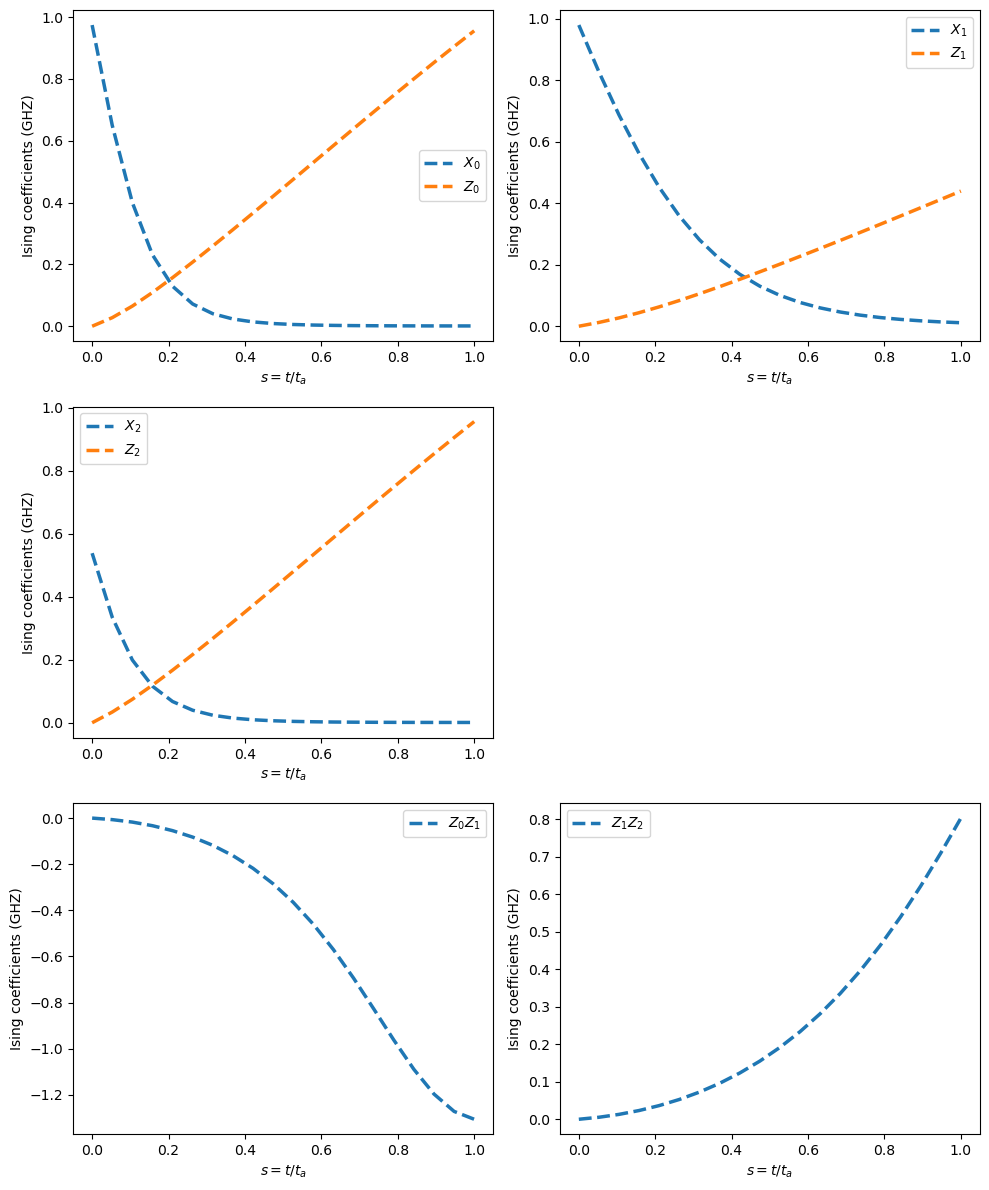

In [18]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 12))

for i in range(3):
    ax1 = plt.subplot(3, 2, i+1)
    
#    plt.plot(s, ising_sw_dict["x_"+str(i)]/2/np.pi, label=r"$X_{0:d}$".format(i), color="C0")
#    plt.plot(s, ising_sw_dict["z_"+str(i)]/2/np.pi, label=r"$Z_{0:d}$".format(i), color="C1")
    
    plt.plot(s, ising_pwsw_dict["x_"+str(i)]/2/np.pi, color="C0", label=r"$X_{0:d}$".format(i), ls='--', lw=2.5 )
    plt.plot(s, ising_pwsw_dict["z_"+str(i)]/2/np.pi, color="C1", label=r"$Z_{0:d}$".format(i), ls='--', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
labels = [[0, 1], [1, 2]]
for i in range(2):
    ax2 = plt.subplot(3, 2, i+5)
    
#    plt.plot(s, ising_sw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, 
#             label=r"$Z_{0:d}Z_{1:d}$".format(labels[i][0], labels[i][1]))
    
    plt.plot(s, ising_pwsw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, color="C0", ls='--', lw=2.5,label=r"$Z_{0:d}Z_{1:d}$".format(labels[i][0], labels[i][1]) )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
plt.tight_layout()
plt.show()

## Finding Circuit fluxes for Custom Pauli Schedules

We discuss how to find appropriate circuit biases that yield a desired Ising schedule. The circuit for each qubit and tunable coupler has two flux biases: $\varphi_{x,k}$ and $\varphi_{z,k}$, that thread their small ($x$) and large ($z$) loops respectively. Here the $x$ and $z$ notation is unrelated to the Pauli operator indices, and to distinguish the two we use a subscript for the loop index and a superscript for the Pauil operator index. The subscript $k$ indexes circuit elements, both the qubits and the couplers. Given a desired Pauli schedule, we wish to find appropriate circuit fluxes that yield that schedule, and we state the problem as 

$$
\{h_k^x, h^z_k, J_{kl}\} \to \{\varphi_{x,k}, \varphi_{z, k}\}.
$$

Here we only consider $\sigma^z \otimes \sigma^z$ couplings, since the typical design of quantum annealing circuits based on flux qubits can only yield strong interactions of this form and other types such as $\sigma^x \otimes \sigma^x$ will be mostly negligible. Nevertheless, the methods we describe here are applicable, with mirror adjustments, to more recent flux qubit variants and coupling circuits that can implement other types of interactions such as $\sigma^x \otimes \sigma^x$. 

To find the circuit fluxes we use **numerical optimization**. For a given set of circuit biases, we can use the previously described method to find the corresponding Pauli coefficients for those biases. Therefore we can easily compare the resulting Pauli coefficients with the ones of our target custom schedule, and if differences are detected we can tune the biases iteratively until we achieve our desired schedule. In this way the biases are tuned by an optimization algorithm. 

For any given set of circuit biases we construct a convex cost function that calculates the difference between our desired Pauli coefficients and the ones that are calculated for those circuit biases as 

$$
\mathcal{C}(\{\varphi_{x,k}, \varphi_{z,k}\}) = \sum_{i} (S_i - \tilde{S}_i)^2,
$$

where $\{\varphi_{x,k}, \varphi_{z,k}\}$ indicates the set of all circuit biases, the summation is over all the qubits and all the different coefficients $S_i \in \{h_k^x, h_k^z, J_{kl}\}$, and $\tilde{S}_i$ is a similar notation for our desired Pauli coefficients, for which we wish to find appropriate circuit biases. This cost function is then minimized in an optimization routine to find the desired circuit biases. Note that although we construct a convex cost function, the optimization problem is not convex in general. 

To solve this optimization problem we apply a few constrains on the physics of the circuit which allow us to narrow the search region. There are three main physical constraints that we can impose in order to simplify the optimization task. The first is to note that the potential of the flux qubits and couplers is periodic with respect to circuit biases, and one needs to choose an *annealing cell* that fixes the bias ranges such that they belong to a chosen periodicity. The second is that the $z$- bias of qubit circuits cannot be tuned beyond a certain value; doing so will break the qubit definition for these circuits. Therefore one needs to place hard constraints on the qubit $z$-biases, which significantly narrows the search region. The third is that the coupler z-biases should all remain fixed at the coupler degeneracy point and do not need to be optimized. Tuning the coupler z-bias away from its degeneracy throws magnetic flux onto its neighboring qubits, which complicates the experimental control of the circuit. It amounts to introducing a correlation between the qubits’ and the couplers’ z-biases (this also makes numerical optimization more challenging). Additionally, keeping the couplers at their degeneracy point improves their coherence (by making them first-order insensitive to frequency fluctuations) and therefore improves the performance of the multi-qubit system, and will not adversely affect the achievable interaction strength between the qubits.

There is a large variety of optimization algorithms and numerical packages that can be utilized for this problem depending on preference and performance. However, the computational cost of the optimization problem scales exponentially with the number of flux qubits and couplers due to use of the SW method for cost function calculations. Additionally, the cost function must be calculated multiple times for the optimization algorithm to converge to a minimum, which further increases the computational cost, making this method viable only for small circuits.  

Considering the unfavorable computational scaling of the method and motivated by the pairwise SW method here an approximate method for finding circuit fluxes that yields the desired Pauli schedules is provided [1]. First, we use a numerical approach similar to the previous one to find the circuit biases for isolated but loaded qubits. With the qubit biases in hand, we then turn on the couplers and calculate the coupling strengths using the pairwise-SW method until we reach our desired coupling strength, for which we save the coupler bias that yielded the desired strength.

Formally, for each isolated but loaded qubit circuit we construct a convex cost function that calculates the difference between the desired single qubit Pauli coefficients and the ones that are calculated the SW transformation as

$$
\mathcal{C}_q (\varphi_{x,k}, \varphi_{z,k}) = (h_{k}^x - \tilde{h}_k^x)^2 + (h_k^z-\tilde{h}_{k}^z)^2,
$$

where $\varphi_{x,k}$  and $\varphi_{z,k}$ are circuit biases for the $k^{th}$ qubit only, $h_k^x$ and $h_z^z$ are the corresponding single qubit Pauli coefficients, and $\tilde{h}_k^x$ and $\tilde{h}_k^z$ are the desired single qubit Pauli coefficients. We use numerical optimization methods to find the circuit biases for all the qubits. 

Next, we consider each coupler circuit and the two qubits that it couples as a joint system similar to the pairwise-SW method, and we fix the qubit biases to the ones that we found earlier using the numerical optimization method. Keeping the coupler’s $z$- bias at its degeneracy, we then turn on the coupler’s $x$-bias we calculate the $\sigma^z \otimes \sigma^z$ interaction between the qubits (essentially creating a lookup table) and continue until we reach our desired interaction strength for that pair of qubits, for which we save the corresponding coupler $\varphi_x$. Repeating this procedure for all the couplers, we can find all the coupler circuit $x$-biases that yield our desired two-qubit Pauli coefficients, while all the coupler $z$-biases are kept at degeneracy. 

The pairwise method gives approximate yet sufficiently accurate results, while scaling only linearly with the system size in comparison to the exponential scaling of the full-SW method. Now, we are ready to code.

In [19]:
ising_dict = {}; pts = 10;
s = np.linspace(0, 1, pts)
ising_dict["points"] = pts

ising_dict["x_0"] = np.linspace(1, 0, pts)*2*np.pi
ising_dict["x_1"] = np.linspace(0.8, 0, pts)*2*np.pi
ising_dict["x_2"] = np.linspace(0.7, 0.05, pts)*2*np.pi

ising_dict["z_0"] = np.linspace(0.0, 1, pts)*2*np.pi
ising_dict["z_1"] = np.linspace(0, 0.8, pts)*2*np.pi
ising_dict["z_2"] = np.linspace(0, 0.9, pts)*2*np.pi

ising_dict["zz_0,1"] = -np.linspace(0.0, 0.9, pts)*2*np.pi
ising_dict["zz_1,2"] = np.linspace(0.0, 0.8, pts)*2*np.pi

After which we compute the fluxes via numerical optimization using pair-wise SW.

In [21]:
custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(ising_dict, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 3
point #9 single qubit residuals: 
 [-9.41061445e-02  6.78638207e-05] 

calculating qubit biases for qubit 2 of 3


/Users/jeanne/Desktop/ETH_QH/CAS-master/cas/elements.py:617: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.50 % for single qubit residuals
  warnings.warn(


point #9 single qubit residuals: 
 [-9.31598542e-02  4.69270929e-05] 

calculating qubit biases for qubit 3 of 3


/Users/jeanne/Desktop/ETH_QH/CAS-master/cas/elements.py:617: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.85 % for single qubit residuals
  warnings.warn(


schedule point 10 / 10
 calculating coupler bias for coupler 1 of 2
schedule point 10 / 10
 calculating coupler bias for coupler 2 of 2


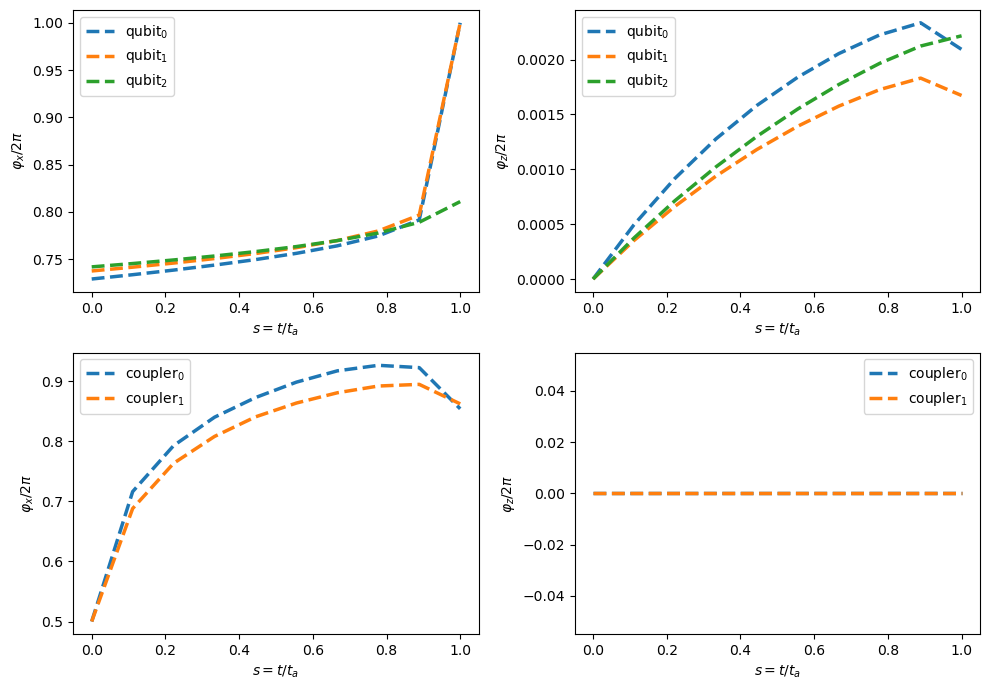

In [22]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 7))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
 #   plt.plot(s, custom_flux_dict_num["phix_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i),)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
 #   plt.plot(s, custom_flux_dict_num["phiz_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)
# plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
 #   plt.plot(s, custom_flux_dict_num["phix_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
 #   plt.plot(s, custom_flux_dict_num["phiz_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
    
plt.tight_layout()
plt.show()

# Problem proposal

Once you know how to implement the annealing and have an idea of how to run a quantum adiabatic algorithm in real hardware we ask you to to provide a design of how to run the AQO for the TSP. Doing a simulation on this problem as above may take several hours. Instead, you may do the follwing steps:

1. Find a totally non-trivial optimization problem in [11] that you can implement with 3-5 qubits. 

2. Design a layout for the circuit.

3. Simulate the spectrum of the circuit using CAS.

4. Propose an Ising annealing schedule. In [1] you can find more information about the appropriate forms of schedules

5. Find the corresponding flux schedule and propose ways to check its correctness. 

6. Once you have completed all these steps, propose ways to scale these procedures to more qubits. Some techniques for finding the gap along the annealing process can be found in [7], [8], [9] and [10]. Can you implement a simulation from one of these papers? Research and propose better techniques to find the flux schedule for a given Ising schedule with a greater amount of qubits.  

## Bibliography

[1] Customized quantum annealing schedules: https://arxiv.org/abs/2103.06461

[2] CAS repository: https://github.com/USCqserver/CAS

[3] Optimal Control for Closed and Open System Quantum Optimization: https://arxiv.org/abs/2107.03517 

[4] scqubits: a Python package for superconducting qubits: https://arxiv.org/abs/2107.08552

[5] scqubits Github repository: https://github.com/scqubits/scqubits

[6] QuTip: https://qutip.org

[7] Adiabatic Spectroscopy and a Variational Quantum Adiabatic Algorithm: https://arxiv.org/abs/2103.01226

[8] Direct estimation of the energy gap between the ground state and excited state with quantum annealing: https://arxiv.org/abs/2007.10561

[9] Simulating quantum circuits by adiabatic computation: improved spectral gap bounds: https://arxiv.org/abs/1906.05233

[10] Spectroscopy on two coupled flux qubits: https://arxiv.org/abs/cond-mat/0308192

[11] Ising formulations of many NP problems: https://arxiv.org/pdf/1302.5843.pdf

[12] Quantum Speedup by Quantum Annealing: https://arxiv.org/pdf/1202.6257.pdf

[13] Anneal-path correction in flux qubits: https://arxiv.org/abs/2002.11217

## Solution

1. Find a totally non-trivial optimization problem in [11] that you can implement with 3-5 qubits.

#### We tackle the following Set Packing Problem:

Consider a set $U=\{1,...6\}$ and a set $\mathcal{V} = \{V_1, V_2, V_3, V_4\}$ of its subsets, where $V_1=\{1, 2, 5\}$, $V_2=\{4, 6\}$, $V_3=\{2, 4\}$, $V_4=\{1, 2, 3, 6\}$. We are looking for the biggest subset $\mathcal{R}$ of $\mathcal{V}$ such that all elements of $\mathcal{R}$ are disjoint.

#### We encode this problem in binary variables in the following way:

We define the binary variables $\{x_i, i\in\{1,...,4\}\}$ as $x_i = 1$ if $V_i \in \mathcal{R}$ and $0$ otherwise.
The constraint of disjonction is encoded in the following Hamiltonian:
$$H_A = A\sum_{i,j=1}^{N}x_ix_j\delta_{i,j}$$
where $\delta_{i,j}=1$ if $V_i$ and $V_j$ are non disjoint, $0$ otherwise:
$$\Delta = (\delta_{i,j})=\begin{pmatrix} 0 & 0 & 1 & 1 \\ 0 & 0 & 1 & 1 \\ 1 & 1 & 0 & 1 \\ 1 & 1 & 1 & 0 \end{pmatrix},$$
while the maximal size of $\mathcal{R}$ is encoded in:
$$H_B = -B\sum_{i=1}^{N}x_i.$$
We need $B<A$ to ensure that the disjonction constraint is well satisfied. We set e.g. $B=2$ and $A=4$.

We then transform this problem into an Ising form, using the variables $\{z_i\}$ such that $x_i=\frac{1-z_i}{2}$. In these variables, the Hamiltonians $H_A$ and $H_B$ read:
$$H_A = - 2 \sum_{i=1}^{N}(\sum_{j=1}^{N}\delta_{i,j})z_i + \sum_{i,j=1}^{N}z_iz_j\delta_{i,j},$$
$$H_B = \sum_{i=1}^{N}z_i,$$
with a constant that does not impact our solution.

Therefore, our problem comes down to the Ising Hamiltonian $H = H_A + H_B$ with Pauli coefficients:
$$h_i^z = 1 - 2 \sum_{j=1}^{N}\delta_{i,j},$$
$$J_{i,j} = \delta_{i,j}.$$

2. Design a layout for the circuit.

Graphic with Q1 connectedd to C1 and C2, Q2 to C3 and C4, Q3 to C1, C3 and C5, and Q4 to C2, C4 and C5. All have the same coupling coefficient M.

3. Simulate the spectrum of the circuit using CAS.

In [25]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit0 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit1 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit2 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit3 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler02 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler03 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler12 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler13 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler23 = cas.Coupler(i_sigma, c_sigma, lc, d)

In [26]:
elements = [coupler02, qubit0, coupler03, qubit3, coupler13, qubit1, coupler12, qubit2, coupler23]

In [27]:
m = 65; m_mat = np.zeros((9,9));

m_mat[0, 1] = m; m_mat[0, 7] = m;
m_mat[2, 1] = m; m_mat[2, 3] = m;
m_mat[4, 3] = m; m_mat[4, 5] = m;
m_mat[6, 5] = m; m_mat[6, 7] = m;
m_mat[8, 7] = m; m_mat[8, 3] = m;

m_mat = -(m_mat + m_mat.T)

In [28]:
trunc_vec = np.array([3, 6, 3, 6, 3, 6, 3, 6, 3])

In [29]:
circuit = cas.AnnealingCircuit(elements, m_mat, trunc_vec)

4. Propose an Ising annealing schedule. In [1] you can find more information about the appropriate forms of schedules

In [32]:
ising_dict = {}; pts = 10;
s = np.linspace(0, 1, pts)
ising_dict["points"] = pts

ising_dict["x_0"] = np.linspace(1, 0, pts)*2*np.pi
ising_dict["x_1"] = np.linspace(1, 0, pts)*2*np.pi
ising_dict["x_2"] = np.linspace(1, 0, pts)*2*np.pi
ising_dict["x_3"] = np.linspace(1, 0, pts)*2*np.pi

ising_dict["z_0"] = np.linspace(0, -3, pts)*2*np.pi
ising_dict["z_1"] = np.linspace(0, -3, pts)*2*np.pi
ising_dict["z_2"] = np.linspace(0, -5, pts)*2*np.pi
ising_dict["z_3"] = np.linspace(0, -5, pts)*2*np.pi

ising_dict["zz_0,1"] = np.linspace(0, 0, pts)*2*np.pi
ising_dict["zz_0,2"] = np.linspace(0, 1, pts)*2*np.pi
ising_dict["zz_0,3"] = np.linspace(0, 1, pts)*2*np.pi
ising_dict["zz_1,2"] = np.linspace(0, 1, pts)*2*np.pi
ising_dict["zz_1,3"] = np.linspace(0, 1, pts)*2*np.pi
ising_dict["zz_2,3"] = np.linspace(0, 1, pts)*2*np.pi

5. Find the corresponding flux schedule and propose ways to check its correctness. 

In [33]:
custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(ising_dict, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 4
point #5 single qubit residuals: 
 [ 0.03886963 -0.66247133] 

point #6 single qubit residuals: 
 [ 0.13104583 -2.07789405] 

point #7 single qubit residuals: 
 [ 0.24728346 -3.42041698] 

point #8 single qubit residuals: 
 [ 0.46672824 -4.56548884] 

point #9 single qubit residuals: 
 [-0.10630039 -3.8228602 ] 

calculating qubit biases for qubit 2 of 4
point #5 single qubit residuals: 
 [ 0.03858291 -0.65621988] 

point #6 single qubit residuals: 
 [ 0.13068352 -2.07033848] 

point #7 single qubit residuals: 
 [ 0.2466428  -3.41163203] 

point #8 single qubit residuals: 
 [ 0.46561102 -4.55554167] 

point #9 single qubit residuals: 
 [-64.1067956  -10.14791653] 

calculating qubit biases for qubit 3 of 4
point #3 single qubit residuals: 
 [ 0.10343623 -1.9077953 ] 

point #4 single qubit residuals: 
 [ 0.26763667 -4.77684537] 

point #5 single qubit residuals: 
 [ 0.44775607 -7.61977971] 

point #6 single qubit residuals: 
 [  0.6593833  -10.

In [34]:
ising_pwsw_dict = circuit.get_ising_pwsw(custom_flux_dict_pwsw, verbose = True)

calculating qubit isings for qubit 1 of 4
calculating qubit isings for qubit 2 of 4
calculating qubit isings for qubit 3 of 4
calculating qubit isings for qubit 4 of 4
calculating coupling strength for coupler 1 of 5
calculating coupling strength for coupler 2 of 5
calculating coupling strength for coupler 3 of 5
calculating coupling strength for coupler 4 of 5
calculating coupling strength for coupler 5 of 5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


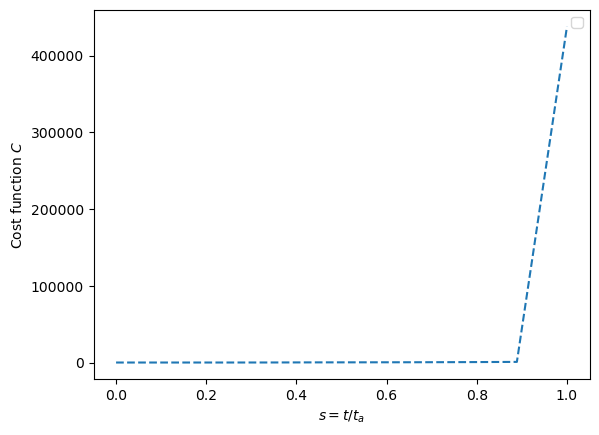

In [41]:
C_arr = np.zeros(pts) # cost function at each point
labels = []
for i in range(3):
    for j in range(i+1, 4):
        labels.append([i,j])

for p in range(pts):
    for i in range(4):
        C_arr[p] += (ising_pwsw_dict["x_"+str(i)][p] - ising_dict["x_"+str(i)][p])**2 + (ising_pwsw_dict["z_"+str(i)][p] - ising_dict["z_"+str(i)][p])**2
        
    for i in range(len(labels)):
        if not str(labels[i][0])+','+str(labels[i][1]) =='0,2' :
            C_arr[p] += (ising_pwsw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])][p] - ising_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])][p])**2
            
fig = plt.figure()
plt.plot(s, C_arr, '--') 
plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Cost function $C$")
plt.legend()
plt.show()

In [37]:
print(ising_pwsw_dict.keys())

dict_keys(['x_0', 'z_0', 'x_1', 'z_1', 'x_2', 'z_2', 'x_3', 'z_3', 'zz_0,3', 'zz_0,1', 'zz_1,2', 'zz_2,3', 'zz_1,3', 'points'])


In [38]:
print(circuit.get_ising_pwsw.__doc__)

Calculates all the Ising coefficients of the system using
        pair-wise Schrieffer-Wolff method.

         Arguments
         ---------
         phi_dict : dictionary
             a dictionary of circuit fluxes. Keys are "phix_i" and "phiz_i" where
             i is the index of the circuit elements. for each key
             there's an array of circuit fluxes during the anneal.
         verbose : bool
             whether to show the progress or not.
             default : False

         Returns
         -------
         ising_pwsw_dict : dictionary
             a dictionary of ising coefficients. Keys are "x_i", "z_i",
             where i are indexes of qubits from 0 to len(qubit_indices)
             For each key there is an array of coefficients during the anneal.
         


In [39]:
print(custom_flux_dict_pwsw.keys())

dict_keys(['points', 'phix_0', 'phiz_0', 'phix_1', 'phiz_1', 'phix_2', 'phiz_2', 'phix_3', 'phiz_3', 'phix_4', 'phiz_4', 'phix_5', 'phiz_5', 'phix_6', 'phiz_6', 'phix_7', 'phiz_7', 'phix_8', 'phiz_8'])


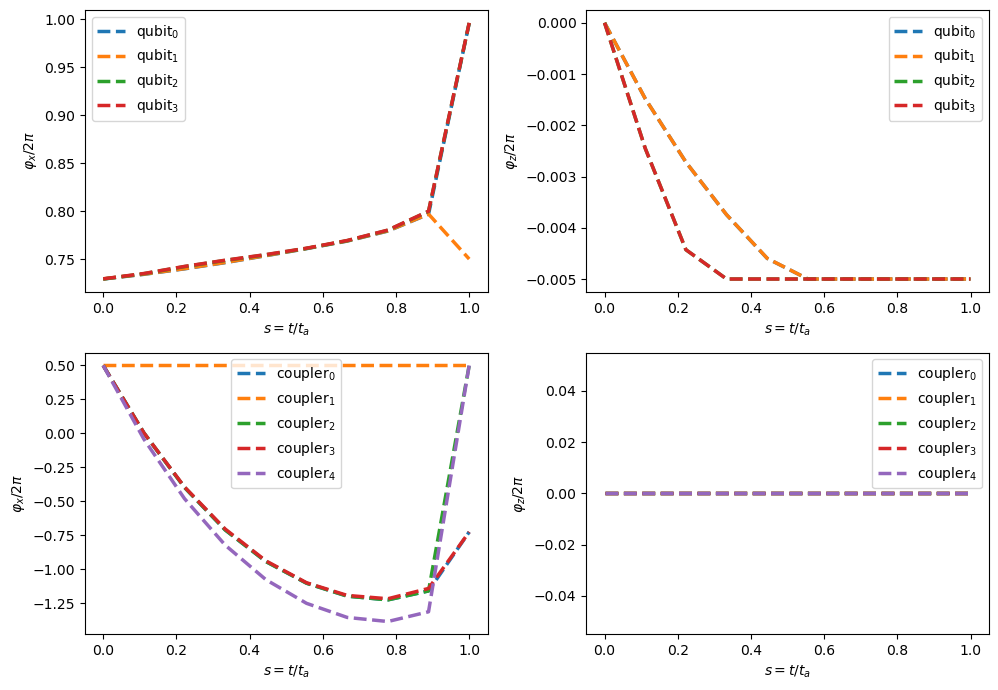

In [42]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 7))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
#   plt.plot(s, custom_flux_dict_num["phix_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i),)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
#   plt.plot(s, custom_flux_dict_num["phiz_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)
# plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
#   plt.plot(s, custom_flux_dict_num["phix_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
#   plt.plot(s, custom_flux_dict_num["phiz_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
    
plt.tight_layout()
plt.show()

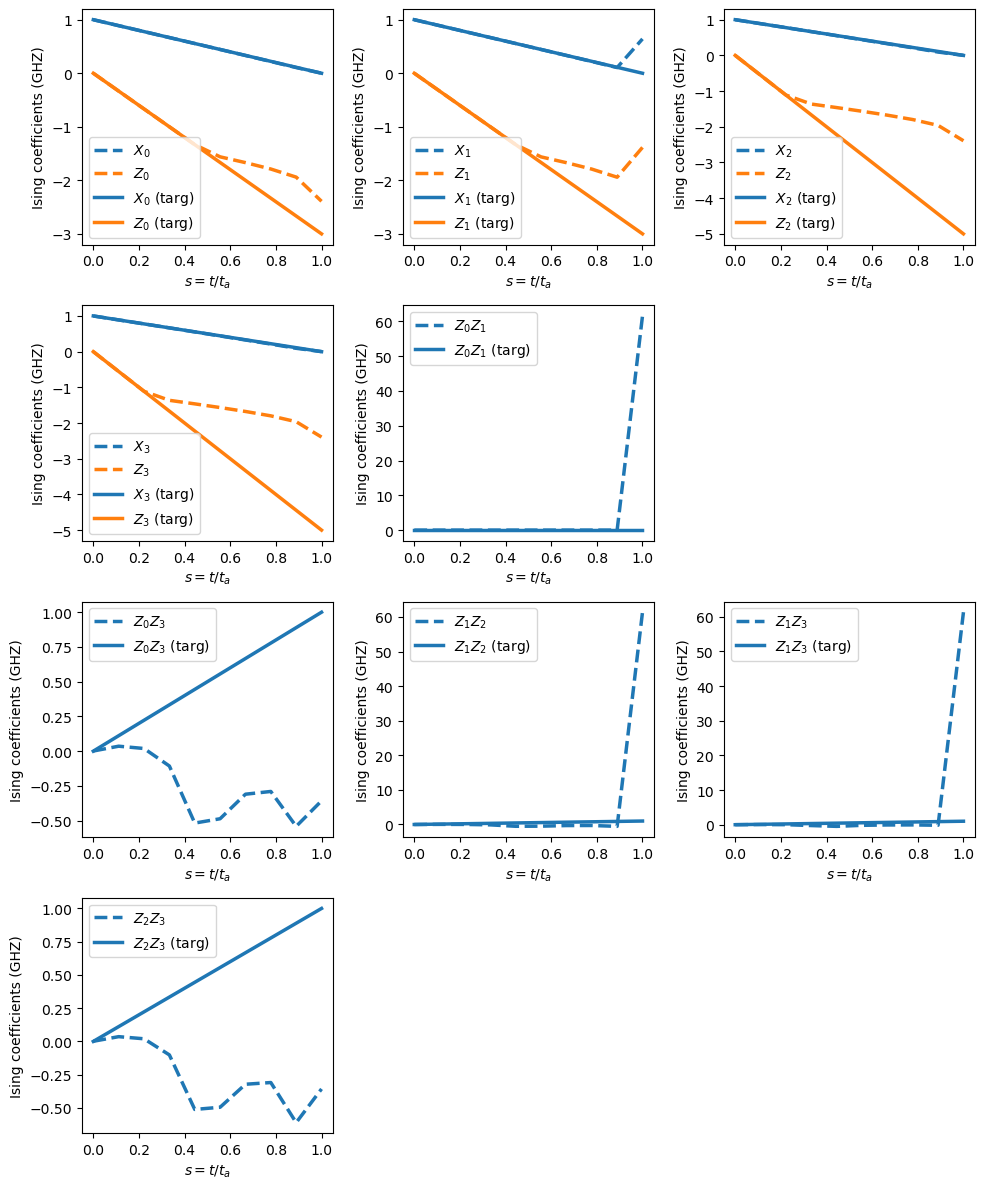

In [51]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 12))

for i in range(4):
        ax1 = plt.subplot(4, 3, i+1)
        
        plt.plot(s, ising_pwsw_dict["x_"+str(i)]/2/np.pi, color="C0", label=r"$X_{0:d}$".format(i), ls='--', lw=2.5 )
        plt.plot(s, ising_pwsw_dict["z_"+str(i)]/2/np.pi, color="C1", label=r"$Z_{0:d}$".format(i), ls='--', lw=2.5 )
        
        plt.plot(s, ising_dict["x_"+str(i)]/2/np.pi, color="C0", label=r"$X_{0:d}$ (targ)".format(i), ls='-', lw=2.5 )
        plt.plot(s, ising_dict["z_"+str(i)]/2/np.pi, color="C1", label=r"$Z_{0:d}$ (targ)".format(i), ls='-', lw=2.5 )
    
        plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
        plt.legend()
    
for i in range(len(labels)):
    if not str(labels[i][0])+','+str(labels[i][1]) =='0,2' :
        ax2 = plt.subplot(4, 3, i+5)
    
        plt.plot(s, ising_pwsw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, color="C0", ls='--', lw=2.5,label=r"$Z_{0:d}Z_{1:d}$".format(labels[i][0], labels[i][1]) )
        plt.plot(s, ising_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, color="C0", ls='-', lw=2.5,label=r"$Z_{0:d}Z_{1:d}$ (targ)".format(labels[i][0], labels[i][1]) )
        
        plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
        plt.legend()
    
plt.tight_layout()
plt.show()